# Benchmarking com os dados de GPS e os dados do Caribe (amostra) 

In [1]:
# Importando os modulos necessarios para o teste dos dados reais

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import ensaio
import pyproj
import numpy as np
import verde as vd
from sklearn.metrics import mean_squared_error


### 1º Experimento - dados de GPS

In [2]:
# Baixando os dados de gps e armazenando o csv na variavel data

path_to_data = ensaio.fetch_alps_gps(version=1)
data = pd.read_csv(path_to_data)

In [3]:
data

,station_id,longitude,latitude,height_m,velocity_east_mmyr,velocity_north_mmyr,velocity_up_mmyr,longitude_error_m,latitude_error_m,height_error_m,velocity_east_error_mmyr,velocity_north_error_mmyr,velocity_up_error_mmyr
0,ACOM,13.514900,46.547935,1774.682,0.2,1.2,1.1,0.0005,0.0009,0.001,0.1,0.1,0.1
1,AFAL,12.174517,46.527144,2284.085,-0.7,0.9,1.3,0.0009,0.0009,0.001,0.1,0.2,0.2
2,AGDE,3.466427,43.296383,65.785,-0.2,-0.2,0.1,0.0009,0.0018,0.002,0.1,0.3,0.3
3,AGNE,7.139620,45.467942,2354.600,0.0,-0.2,1.5,0.0009,0.0036,0.004,0.2,0.6,0.5
4,AIGL,3.581261,44.121398,1618.764,0.0,0.1,0.7,0.0009,0.0009,0.002,0.1,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,WLBH,7.351299,48.415171,819.069,0.0,-0.2,-2.8,0.0005,0.0009,0.001,0.1,0.2,0.2
182,WTZR,12.878911,49.144199,666.025,0.1,0.2,-0.1,0.0005,0.0005,0.001,0.1,0.1,0.1
183,ZADA,15.227590,44.113177,64.307,0.2,3.1,-0.3,0.0018,0.0036,0.004,0.2,0.4,0.4
184,ZIMM,7.465278,46.877098,956.341,-0.1,0.4,1.0,0.0005,0.0009,0.001,0.1,0.1,0.1


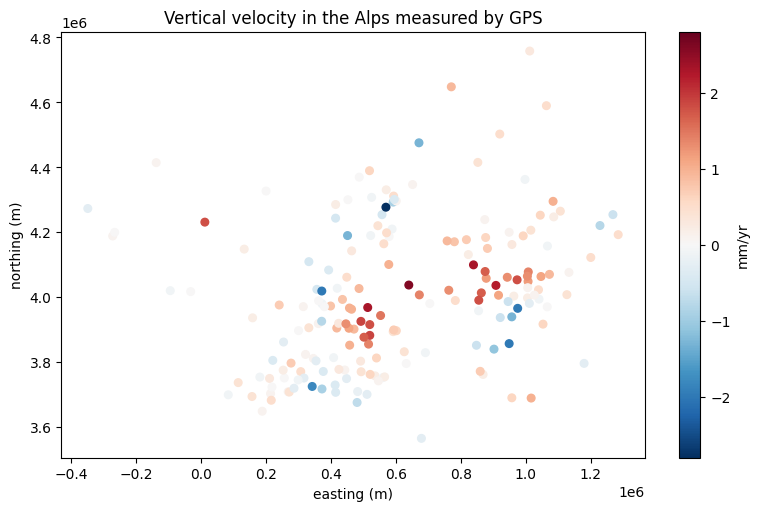

In [4]:
# Transformando as coordenadas em pontos cartesianos
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
easting, northing = projection(data.longitude, data.latitude)

# Plotando os resultados adquiridos em pontos cartesianos
# Get the maximum absolute value
scale = vd.maxabs(data.velocity_up_mmyr)

fig, ax = plt.subplots(1, 1, figsize=(8, 5), layout="constrained")
ax.set_aspect("equal")
# Use scale to set the vmin and vmax and center the colorbar
tmp = ax.scatter(
    easting,
    northing,
    c=data.velocity_up_mmyr,
    s=30,
    cmap="RdBu_r",
    vmin=-scale,
    vmax=scale,
)
fig.colorbar(tmp, label="mm/yr")
ax.set_title("Vertical velocity in the Alps measured by GPS")
ax.set_xlabel("easting (m)")
ax.set_ylabel("northing (m)")
plt.show()


--- Estatísticas Descritivas por Versão ---
         count      mean       std       min       25%       50%       75%  \
Versão                                                                       
32 bits   20.0  0.033156  0.081435  0.008338  0.009802  0.011963  0.014939   
64 bits   20.0  0.037965  0.128705  0.005005  0.005924  0.008375  0.013466   

              max  
Versão             
32 bits  0.373887  
64 bits  0.584534  


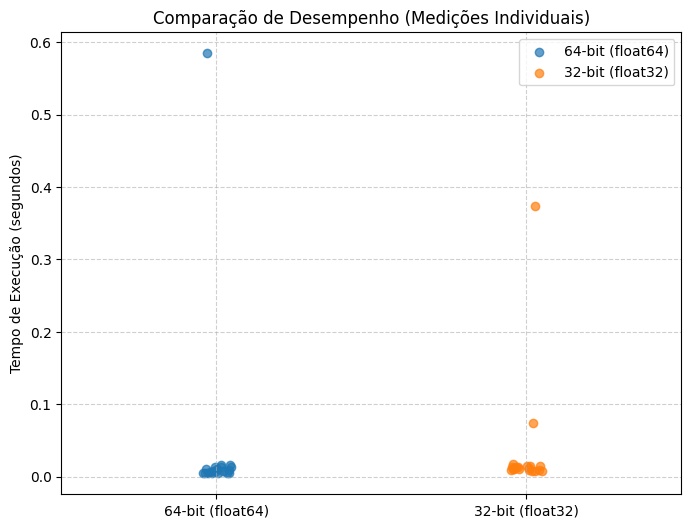

In [5]:
## Código com benchmarking ## 
resultados_benchmark_spline = []
n_repeticoes = 20

#Realizamos os testes com fit utilizando os 64 bits

for i in range(n_repeticoes):

    start_time = time.perf_counter()
    # Utilizar a classe Spline para interpolar os dados do GPS

    # Cria-se uma instância de Spline
    spline_64 = vd.Spline()
    # Realiza-se a interpolação com os dados passados (easting, northing)
    spline_64.fit((easting, northing), data.velocity_up_mmyr)
    end_time = time.perf_counter()

    duracao = end_time - start_time
    resultados_benchmark_spline.append({
        "Versão": "64 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })


# Mudando o tipo de dado na entrada -  obs: bugou mudar na marra
easting_32 = easting.astype("float32")
northing_32 = northing.astype("float32")
data_velocity_32 = data.velocity_up_mmyr.astype("float32")    
    
# Realizamos os testes com fit utilizando 32 bits
for i in range(n_repeticoes):

    start_time = time.perf_counter()
    # Utilizar a classe Spline para interpolar os dados do GPS

    # Cria-se uma instância de Spline
    spline_32 = vd.Spline()
    # Realiza-se a interpolação com os dados passados (easting, northing)
    spline_32.fit((easting_32, northing_32), data_velocity_32)
    end_time = time.perf_counter()

    duracao = end_time - start_time
    resultados_benchmark_spline.append({
        "Versão": "32 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })


# Transforma a lista em um dataframe para isolar as informações desejadas
df_resultados = pd.DataFrame(resultados_benchmark_spline)

# Printa os dados estatísticos de cada versão (média, mediana, quartis)
print("\n--- Estatísticas Descritivas por Versão ---")
print(df_resultados.groupby("Versão")["Duração"].describe())

df_resultados

# Resultados muito infímos - tempos de execução muito curtos
# Tomando os tempos de execução de cada versão
tempos_64bit = df_resultados[df_resultados["Versão"] == "64 bits"]["Duração"]
tempos_32bit = df_resultados[df_resultados["Versão"] == "32 bits"]["Duração"]

fig, ax = plt.subplots(figsize=(8, 6))

# Posições no eixo X para cada categoria
x_64 = np.ones(len(tempos_64bit)) # Todos os pontos na posição x=1
x_32 = np.full(len(tempos_32bit), 2) # Todos os pontos na posição x=2

# Adicionamos um pequeno "jitter" (ruído) no eixo X para que os pontos
# não se sobreponham perfeitamente, facilitando a visualização.
jitter_strength = 0.05
x_64_jitter = x_64 + np.random.uniform(-jitter_strength, jitter_strength, len(x_64))
x_32_jitter = x_32 + np.random.uniform(-jitter_strength, jitter_strength, len(x_32))

# Plotando os pontos
ax.scatter(x_64_jitter, tempos_64bit, alpha=0.7, label="64-bit (float64)")
ax.scatter(x_32_jitter, tempos_32bit, alpha=0.7, label="32-bit (float32)")

# Configurando o eixo X para mostrar os nomes das categorias
ax.set_xticks([1, 2])
ax.set_xticklabels(["64-bit (float64)", "32-bit (float32)"])
ax.set_xlim(0.5, 2.5) # Limites para centralizar os pontos

ax.set_title('Comparação de Desempenho (Medições Individuais)')
ax.set_ylabel('Tempo de Execução (segundos)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.savefig("comparacao_pontos_GPS.png")
plt.show()


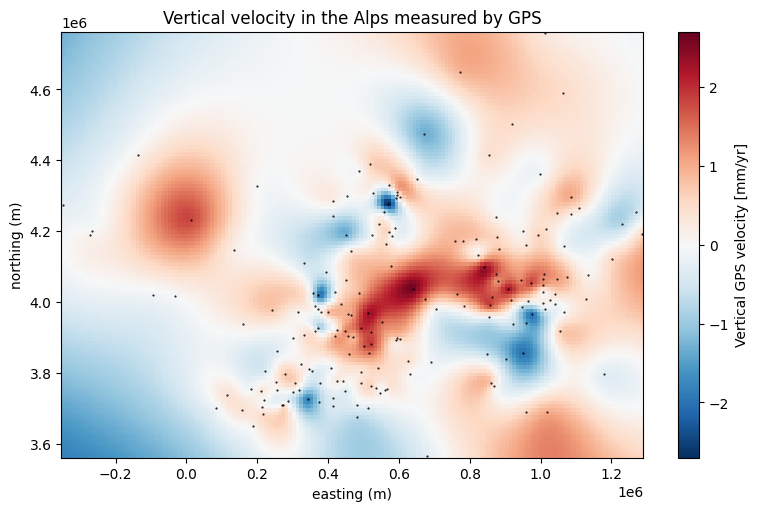

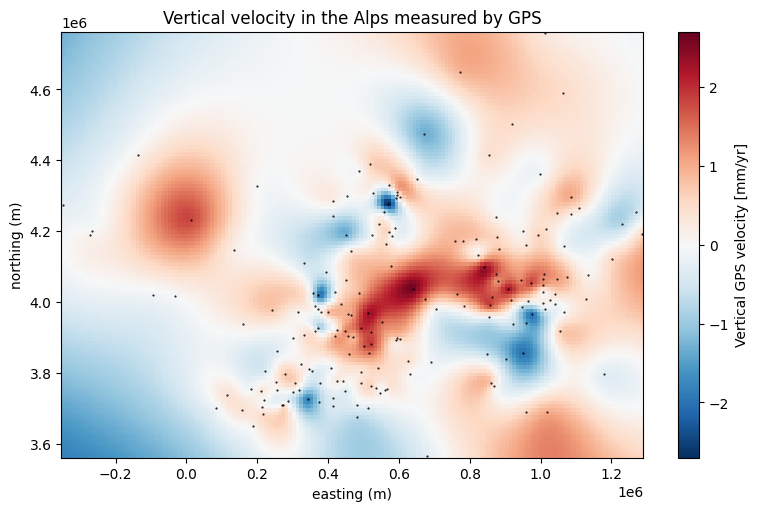

In [5]:
# Criação dos grids e plotagem para visualização

# Grid utilizando dados com 64 bits
grid_64 = spline_64.grid(spacing=10e3)
grid_64

# Rename the data variable and add some metadata
grid_64 = grid_64.rename(scalars="velocity_up")
grid_64.velocity_up.attrs["long_name"] = "Vertical GPS velocity"
grid_64.velocity_up.attrs["units"] = "mm/yr"

# Make the plot again but plot the data locations on top
fig, ax = plt.subplots(1, 1, figsize=(8, 5), layout="constrained")
ax.set_aspect("equal")
grid_64.velocity_up.plot(ax=ax)
ax.plot(easting, northing, ".k", markersize=1)
ax.set_title("Vertical velocity in the Alps measured by GPS")
ax.set_xlabel("easting (m)")
ax.set_ylabel("northing (m)")
plt.show()


# Grid utilizando dados com 32 bits
grid_32 = spline_64.grid(spacing=10e3)
grid_32

# Rename the data variable and add some metadata
grid_32 = grid_32.rename(scalars="velocity_up")
grid_32.velocity_up.attrs["long_name"] = "Vertical GPS velocity"
grid_32.velocity_up.attrs["units"] = "mm/yr"

# Make the plot again but plot the data locations on top
fig, ax = plt.subplots(1, 1, figsize=(8, 5), layout="constrained")
ax.set_aspect("equal")
grid_32.velocity_up.plot(ax=ax)
ax.plot(easting, northing, ".k", markersize=1)
ax.set_title("Vertical velocity in the Alps measured by GPS")
ax.set_xlabel("easting (m)")
ax.set_ylabel("northing (m)")
plt.show()

Utilizar o MSE para definir diferenças na interpolação com precisões diferentes.

In [6]:
# Extrair os arrays de dados de dentro dos grids 
valores_64 = grid_64.velocity_up.values
valores_32 = grid_32.velocity_up.values

# Calcule o MSE
# O primeiro argumento é considerado o valor "verdadeiro" e o segundo a "predição"
mse = mean_squared_error(valores_64, valores_32)
print(f"O Erro Quadrático Médio (MSE) entre as versões é: {mse}")

# Raiz do MSE
rmse = np.sqrt(mse)
print(f"A Raiz do Erro Quadrático Médio (RMSE) é: {rmse:.4f} metros")

O Erro Quadrático Médio (MSE) entre as versões é: 0.0
A Raiz do Erro Quadrático Médio (RMSE) é: 0.0000 metros



___________________________________________


________________________________________________________

### 2º Experimento - teste do Caribe com maior número de pontos para forçar o modelo de interpolação.  

In [2]:
import pygmt

fname = ensaio.fetch_caribbean_bathymetry(version=2)

In [3]:
data_caribe = pd.read_csv(fname)
data_caribe

,survey_id,latitude,longitude,bathymetry_m
0,86005311,16.09652,-61.52117,-187
1,86005311,16.09415,-61.52104,-177
2,86005311,16.09177,-61.52091,-185
3,86005311,16.08940,-61.52078,-188
4,86005311,16.08703,-61.52066,-192
...,...,...,...,...
294316,JR336,15.28529,-57.01258,-5276
294317,JR336,15.28705,-57.00994,-5277
294318,JR336,15.28883,-57.00732,-5278
294319,JR336,15.29057,-57.00467,-5277


In [ ]:
# --- Definindo subamostra com base em uma Região de Interesse ---
# Formato: (longitude_oeste, longitude_leste, latitude_sul, latitude_norte)
regiao_interesse = (-62, -61, 12, 13) # Exemplo: Região das Pequenas Antilhas

col_lon = "longitude"
col_lat = "latitude"

# Restringe os pontos ao intervalo de coordenadas desejado
condicao_lon = (data_caribe[col_lon] >= regiao_interesse[0]) & (data_caribe[col_lon] <= regiao_interesse[1])
condicao_lat = (data_caribe[col_lat] >= regiao_interesse[2]) & (data_caribe[col_lat] <= regiao_interesse[3])
#Aplica as condições nos dados completos
data_limitado = data_caribe[condicao_lat & condicao_lon]


# --- Tomando número especificado de pontos aleatórios dentre os remanescentes ---
n_pontos = 4000

if(len(data_limitado) < n_pontos):
    print("Usando todos os pontos disponíveis na área.")
    data_final = data_limitado.copy()
else:
    print(f"Selecionando aleatoriamente {n_pontos} pontos da área de interesse...")
    data_final = data_limitado.sample(n=n_pontos, random_state=42)

    




Selecionando aleatoriamente 3000 pontos da área de interesse...


In [5]:
## Código com benchmarking ## 
resultados_benchmark_spline = []
n_repeticoes = 5

# Transformando as coordenadas em pontos cartesianos
projection = pyproj.Proj(proj="merc", lat_ts=data_final.latitude.mean())
easting, northing = projection(data_final.longitude, data_final.latitude)


for i in range(n_repeticoes):
    
    start_time = time.perf_counter()
    # Utilizar a classe Spline para interpolar os dados do GPS

    
    # Utilizar a classe Spline para interpolar os dados do GPS
    # Cria-se uma instância de Spline
    spline_caribe_64 = vd.Spline()

    # Realiza-se a interpolação com os dados passados (easting, northing)
    spline_caribe_64.fit((easting, northing), data_final.bathymetry_m) 

    end_time = time.perf_counter()

    duracao = end_time - start_time

    resultados_benchmark_spline.append({
        "Versão": "64 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })

# Mudando o tipo de dado na entrada -  obs: bugou mudar na marra
#easting_32 = easting.astype("float32")
#northing_32 = northing.astype("float32")
#data_bathymetry_32 = data_final.bathymetry_m.astype("float32")    
    
# Realizamos os testes com fit utilizando 32 bits
for i in range(n_repeticoes):

    start_time = time.perf_counter()
    # Utilizar a classe Spline para interpolar os dados do GPS

    # Cria-se uma instância de Spline
    spline_caribe_32 = vd.Spline()
    # Realiza-se a interpolação com os dados passados (easting, northing)
    #spline_caribe_32.fit((easting_32, northing_32), data_bathymetry_32)
    spline_caribe_32.fit((easting, northing), data_final.bathymetry_m, dtype="float32")
    end_time = time.perf_counter()

    duracao = end_time - start_time
    resultados_benchmark_spline.append({
        "Versão": "32 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })



# Transforma a lista em um dataframe para isolar as informações desejadas
df_resultados = pd.DataFrame(resultados_benchmark_spline)

# Printa os dados estatísticos de cada versão (média, mediana, quartis)
print("\n--- Estatísticas Descritivas por Versão ---")
print(df_resultados.groupby("Versão")["Duração"].describe())

df_resultados



    




--- Estatísticas Descritivas por Versão ---
         count      mean       std       min       25%       50%       75%  \
Versão                                                                       
32 bits    5.0  3.350863  0.098816  3.258766  3.264513  3.355708  3.374308   
64 bits    5.0  7.593779  0.464994  7.269560  7.331831  7.470812  7.487595   

             max  
Versão            
32 bits  3.50102  
64 bits  8.40910  


,Versão,Rodada,Duração
0,64 bits,1,8.409100
1,64 bits,2,7.487595
2,64 bits,3,7.331831
3,64 bits,4,7.470812
4,64 bits,5,7.269560
5,32 bits,1,3.501020
6,32 bits,2,3.264513
7,32 bits,3,3.258766
8,32 bits,4,3.355708
9,32 bits,5,3.374308


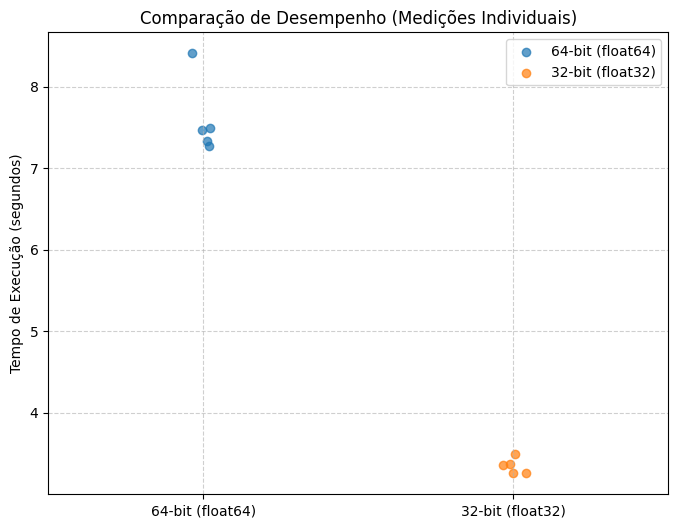

/tmp/ipykernel_14911/982461831.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])


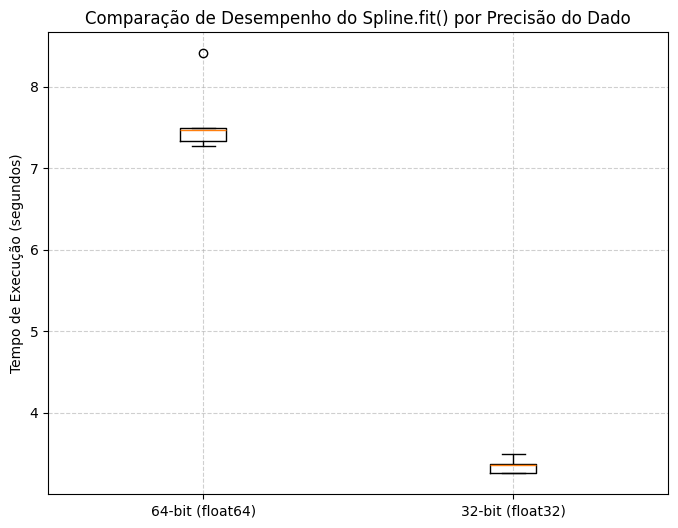

In [6]:
# Tomando os tempos de execução de cada versão
tempos_64bit = df_resultados[df_resultados["Versão"] == "64 bits"]["Duração"]
tempos_32bit = df_resultados[df_resultados["Versão"] == "32 bits"]["Duração"]

fig, ax = plt.subplots(figsize=(8, 6))

# Posições no eixo X para cada categoria
x_64 = np.ones(len(tempos_64bit)) # Todos os pontos na posição x=1
x_32 = np.full(len(tempos_32bit), 2) # Todos os pontos na posição x=2

# Adicionamos um pequeno "jitter" (ruído) no eixo X para que os pontos
# não se sobreponham perfeitamente, facilitando a visualização.
jitter_strength = 0.05
x_64_jitter = x_64 + np.random.uniform(-jitter_strength, jitter_strength, len(x_64))
x_32_jitter = x_32 + np.random.uniform(-jitter_strength, jitter_strength, len(x_32))

# Plotando os pontos
ax.scatter(x_64_jitter, tempos_64bit, alpha=0.7, label="64-bit (float64)")
ax.scatter(x_32_jitter, tempos_32bit, alpha=0.7, label="32-bit (float32)")

# Configurando o eixo X para mostrar os nomes das categorias
ax.set_xticks([1, 2])
ax.set_xticklabels(["64-bit (float64)", "32-bit (float32)"])
ax.set_xlim(0.5, 2.5) # Limites para centralizar os pontos

ax.set_title('Comparação de Desempenho (Medições Individuais)')
ax.set_ylabel('Tempo de Execução (segundos)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.savefig("comparacao_pontos_caribe.png")
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])
ax.set_title('Comparação de Desempenho do Spline.fit() por Precisão do Dado')
ax.set_ylabel('Tempo de Execução (segundos)')
ax.grid(True, linestyle='--', alpha=0.6)
plt.savefig("comparacao_precisao_dados_caribe.png")
plt.show()

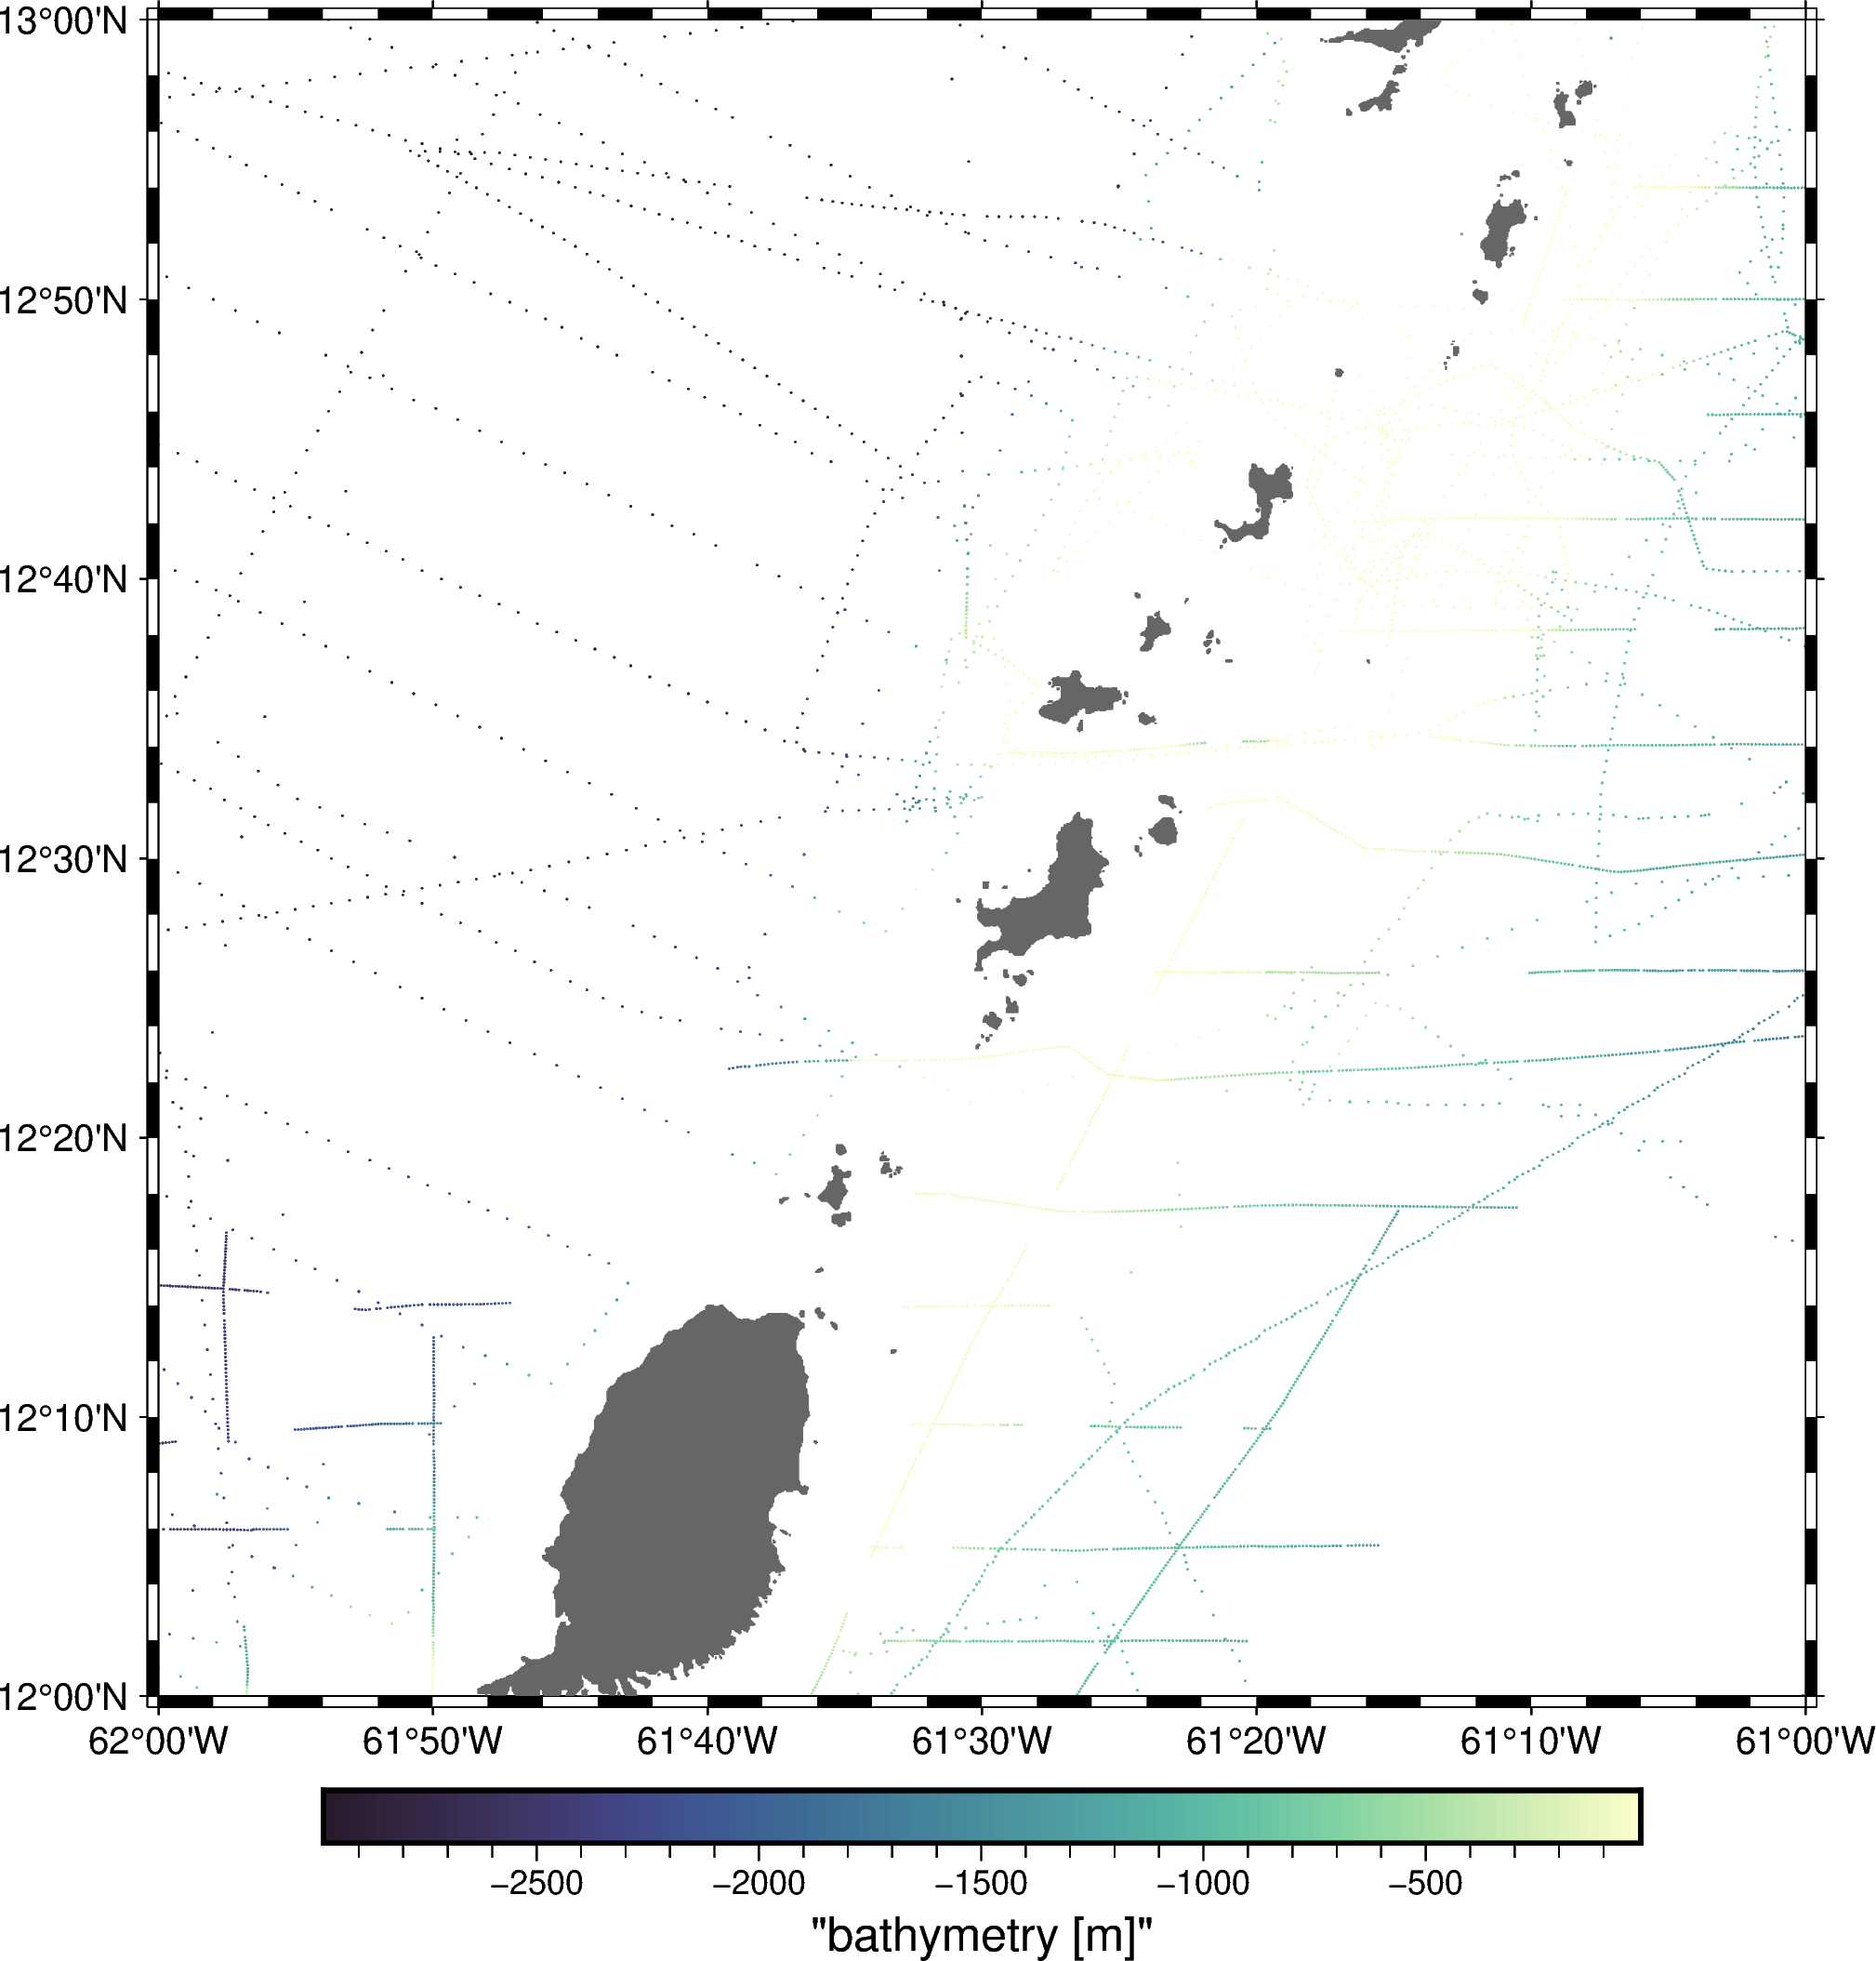

In [33]:
# Mostrar quanta informação foi utilizada

fig = pygmt.Figure()
pygmt.makecpt(
    cmap="cmocean/topo+h",
    series=[data_final.bathymetry_m.min(), data_final.bathymetry_m.max()],
)
fig.plot(
    x=data_final.longitude,
    y=data_final.latitude,
    fill=data_final.bathymetry_m,
    cmap=True,
    style="c0.02c",
    projection="M15c",
    frame=True,
)
fig.colorbar(frame='af+l"bathymetry [m]"')
fig.coast(land="#666666")
fig.show()


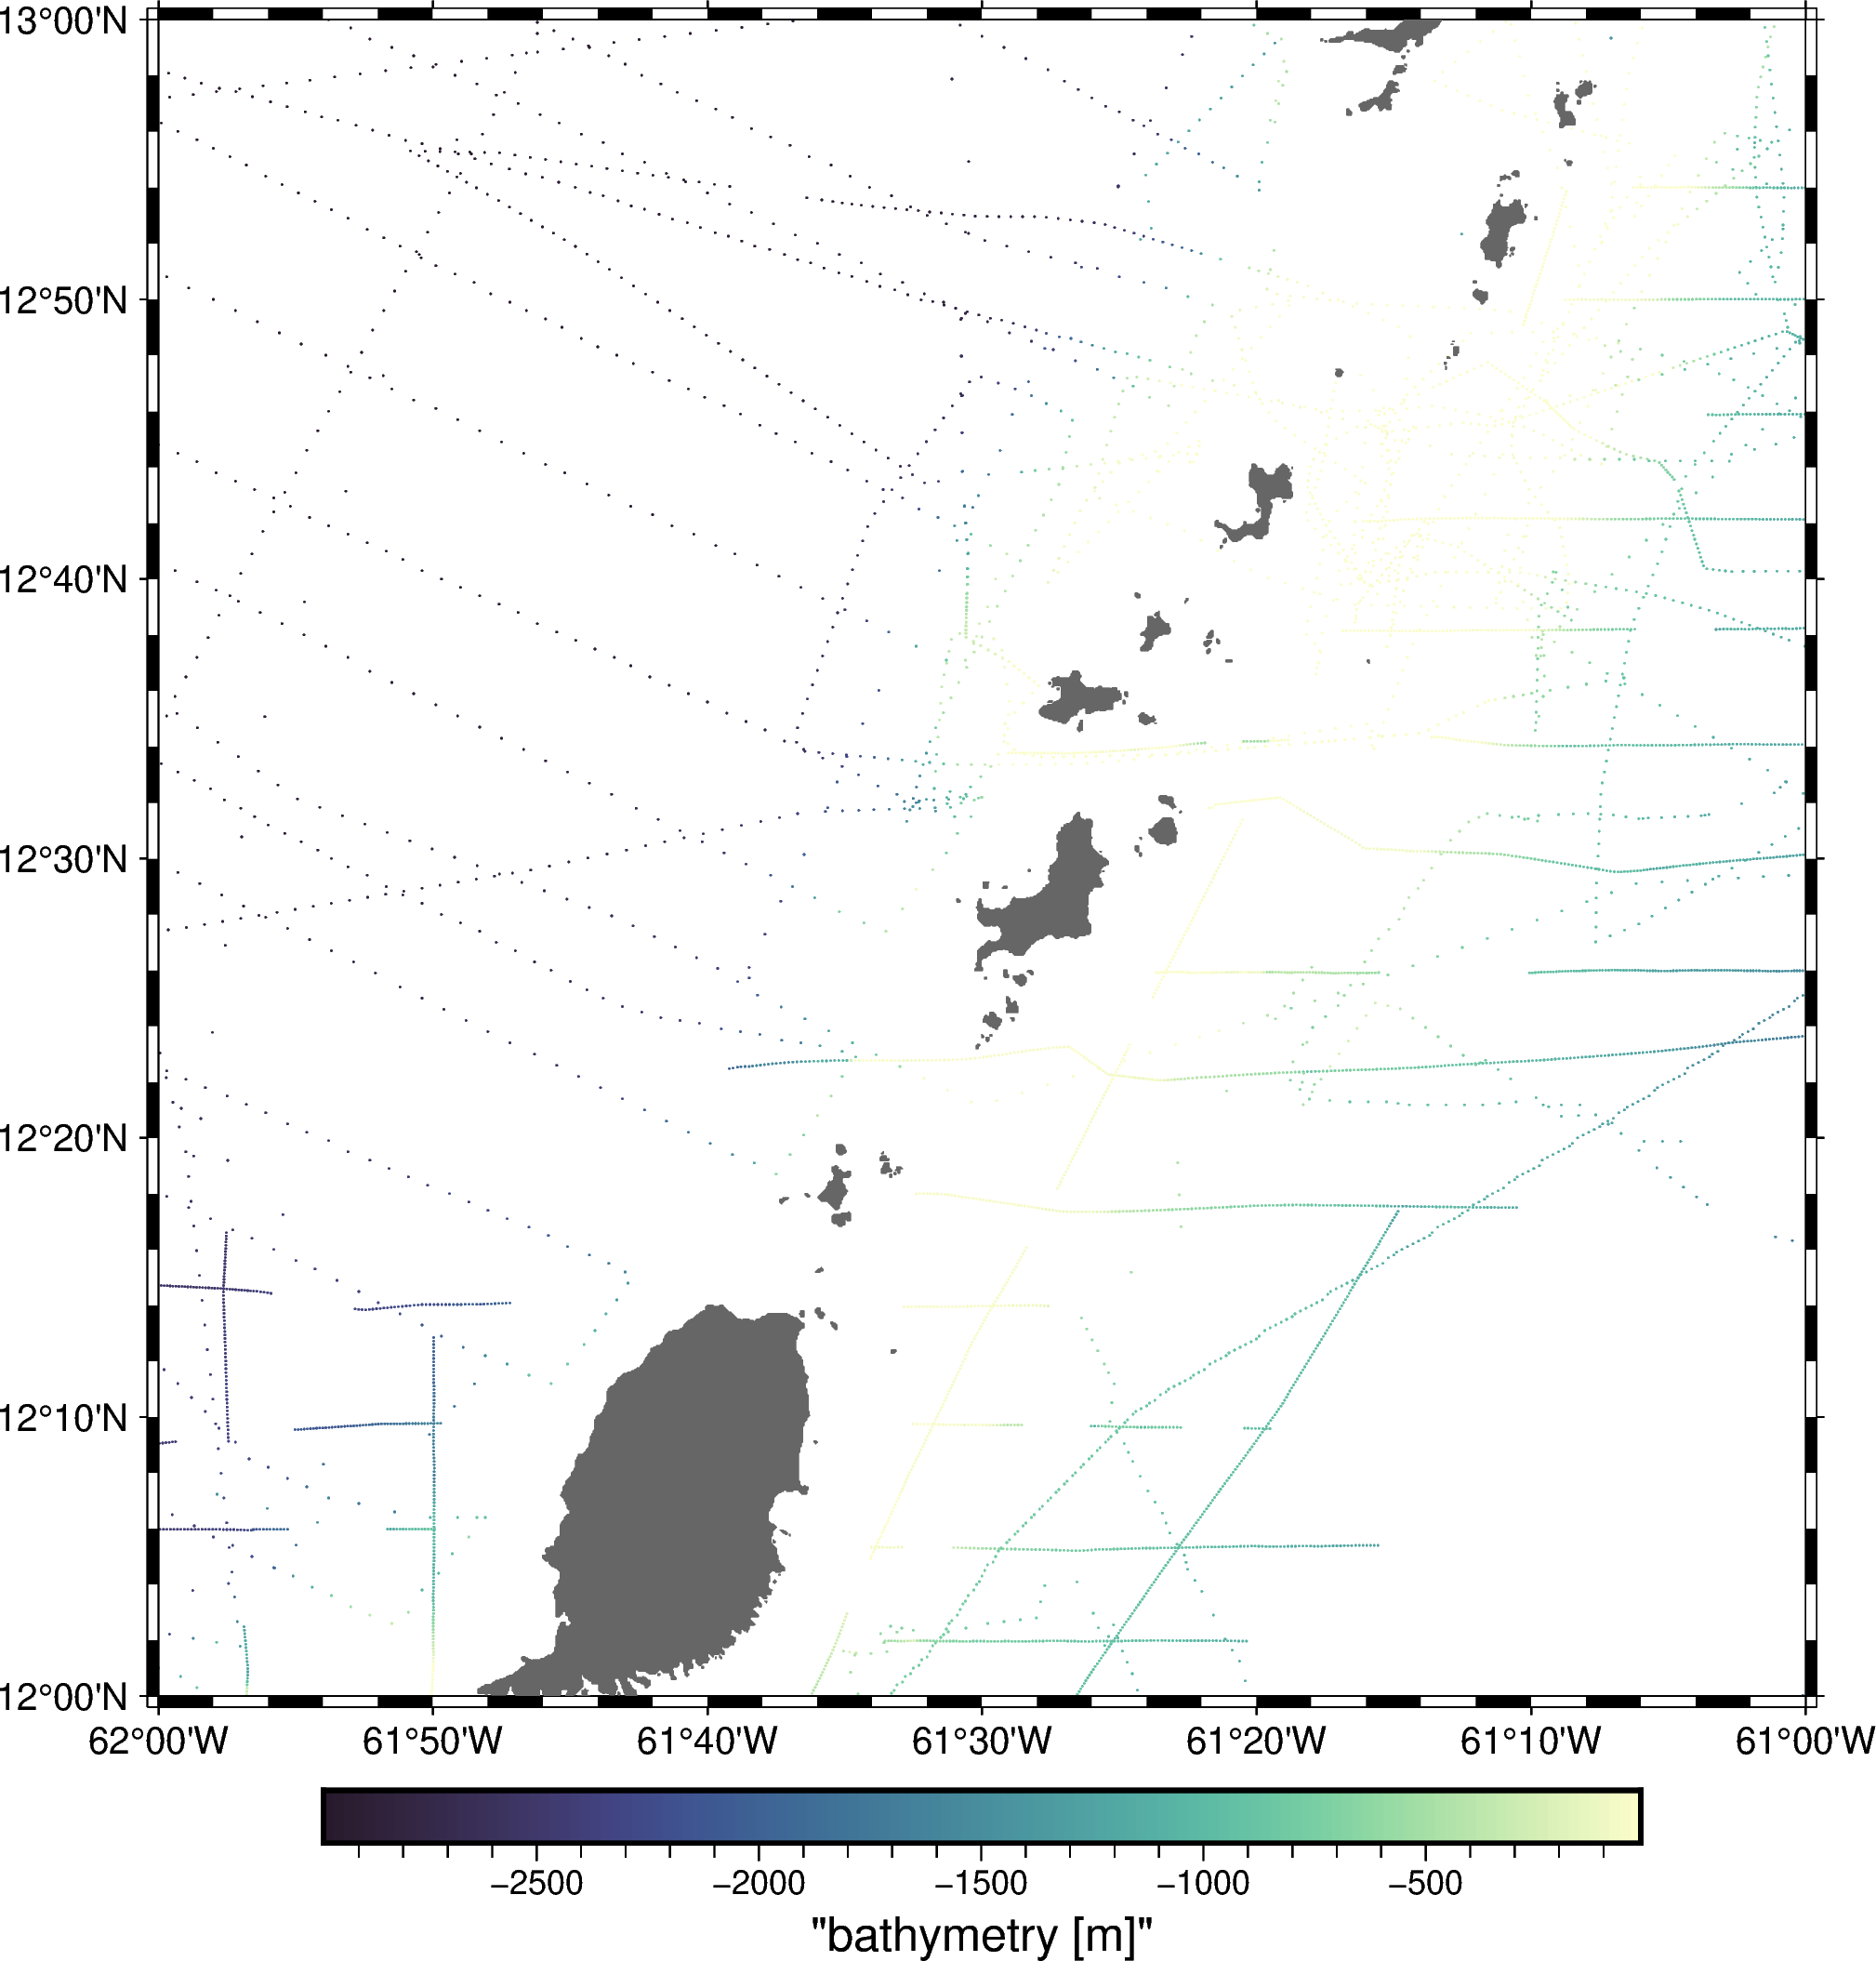

In [34]:
# Mostrar quanta informação havia para ser usada

fig = pygmt.Figure()
pygmt.makecpt(
    cmap="cmocean/topo+h",
    series=[data_limitado.bathymetry_m.min(), data_limitado.bathymetry_m.max()],
)
fig.plot(
    x=data_limitado.longitude,
    y=data_limitado.latitude,
    fill=data_limitado.bathymetry_m,
    cmap=True,
    style="c0.02c",
    projection="M15c",
    frame=True,
)
fig.colorbar(frame='af+l"bathymetry [m]"')
fig.coast(land="#666666")
fig.show()


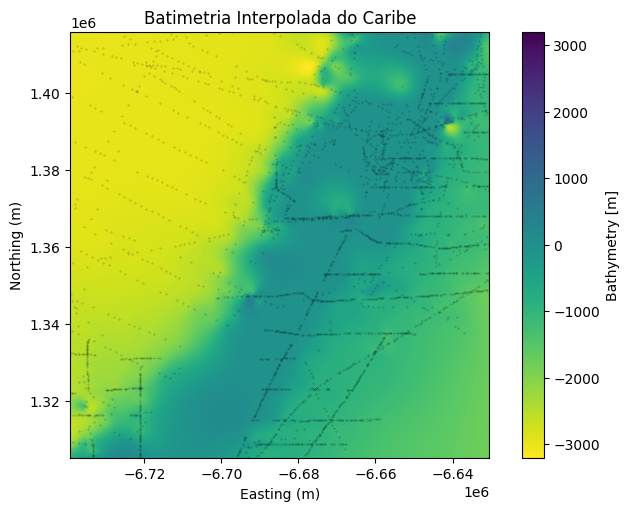

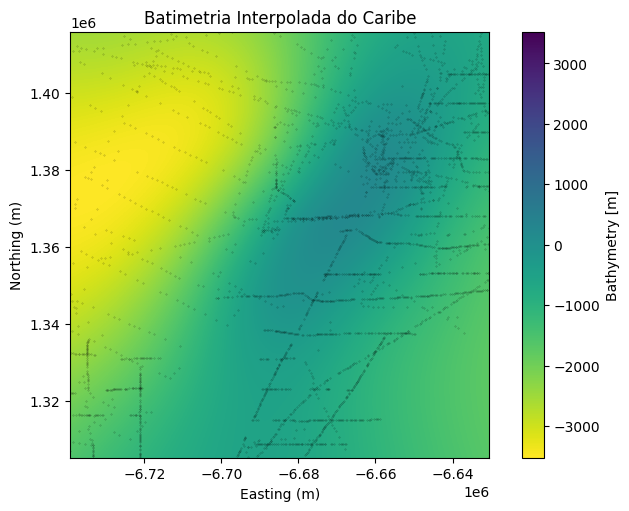

In [14]:
# Criação dos grids e plotagem para visualização da interpolação

# Grid com dados de 64 bits
grid_caribe_64 = spline_caribe_64.grid(spacing=10e1)
grid_caribe_64

# Renomeando e adicionando metadados 
grid_caribe_64 = grid_caribe_64.rename(scalars="bathymetry")
grid_caribe_64.bathymetry.attrs["long_name"] = "Bathymetry"
grid_caribe_64.bathymetry.attrs["units"] = "m"

# Refaz a plotagem but plot the data locations on top
fig, ax = plt.subplots(1, 1, figsize=(8, 5), layout="constrained")
ax.set_aspect("equal")
grid_caribe_64.bathymetry.plot(ax=ax, cmap="viridis_r")
ax.plot(easting, northing, ".k", markersize=0.5, alpha=0.4)
# Define o título e os rótulos dos eixos corretamente
ax.set_title("Batimetria Interpolada do Caribe")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")

plt.show()


# Grid com dados de 32 bits
grid_caribe_32 = spline_caribe_32.grid(spacing=10e1)
grid_caribe_32

# Renomeando e adicionando metadados 
grid_caribe_32 = grid_caribe_32.rename(scalars="bathymetry")
grid_caribe_32.bathymetry.attrs["long_name"] = "Bathymetry"
grid_caribe_32.bathymetry.attrs["units"] = "m"

# Refaz a plotagem but plot the data locations on top
fig, ax = plt.subplots(1, 1, figsize=(8, 5), layout="constrained")
ax.set_aspect("equal")
grid_caribe_32.bathymetry.plot(ax=ax, cmap="viridis_r")
ax.plot(easting, northing, ".k", markersize=0.5, alpha=0.4)
# Define o título e os rótulos dos eixos corretamente
ax.set_title("Batimetria Interpolada do Caribe")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")

plt.show()

Utilizar o MSE para definir diferenças na interpolação com precisões diferentes.

In [15]:
# Extrair os arrays de dados de dentro dos grids 
valores_64 = grid_caribe_64.bathymetry.values
valores_32 = grid_caribe_32.bathymetry.values

# Calcule o MSE
# O primeiro argumento é considerado o valor "verdadeiro" e o segundo a "predição"
mse = mean_squared_error(valores_64, valores_32)
print(f"O Erro Quadrático Médio (MSE) entre as versões é: {mse}")

# Raiz do MSE
rmse = np.sqrt(mse)
print(f"A Raiz do Erro Quadrático Médio (RMSE) é: {rmse:.4f} metros")

O Erro Quadrático Médio (MSE) entre as versões é: 159772.0644555162
A Raiz do Erro Quadrático Médio (RMSE) é: 399.7150 metros


__________________________________________________________________________

________________________________________________________________________